In [1]:
%%capture
#!pip install datasets pandas matplotlib seaborn --quiet
!pip install -U datasets fsspec --quiet

In [2]:
#Import Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%%capture
# Load the IMDB dataset from HuggingFace
dataset = load_dataset("amazon_polarity")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [5]:
# Convert entire train split (can be big, so here we sample for EDA)
df = dataset['train'].to_pandas()

# Check columns
print(df.columns)

# Preview data
print(df.tail())

Index(['label', 'title', 'content'], dtype='object')
         label                                  title  \
3599995      0                          Don't do it!!   
3599996      0          Looks nice, low functionality   
3599997      0             compact, but hard to clean   
3599998      0                     what is it saying?   
3599999      1  Makes My Blood Run Red-White-And-Blue   

                                                   content  
3599995  The high chair looks great when it first comes...  
3599996  I have used this highchair for 2 kids now and ...  
3599997  We have a small house, and really wanted two o...  
3599998  not sure what this book is supposed to be. It ...  
3599999  I agree that every American should read this b...  


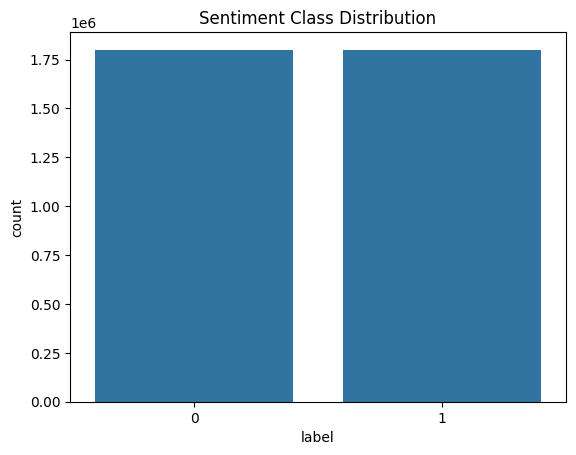

label
1    1800000
0    1800000
Name: count, dtype: int64


In [6]:
# Plot sentiment label counts
sns.countplot(x='label', data=df)
plt.title('Sentiment Class Distribution')
plt.show()

# Print counts
print(df['label'].value_counts())

In [7]:
# Check nulls
print(df.isnull().sum())

label      0
title      0
content    0
dtype: int64


In [8]:
# Check duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


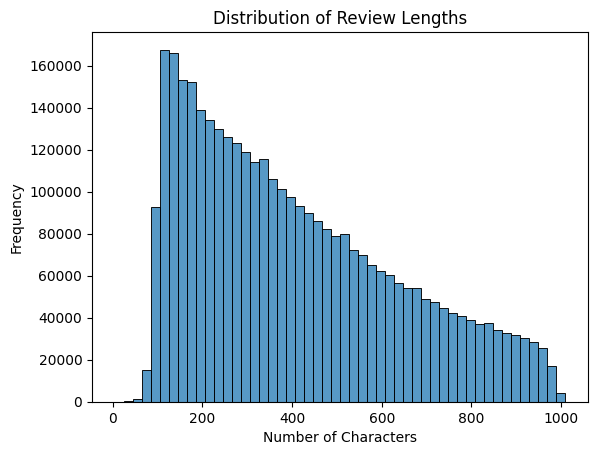

count    3.600000e+06
mean     4.051396e+02
std      2.342711e+02
min      4.000000e+00
25%      2.070000e+02
50%      3.560000e+02
75%      5.660000e+02
max      1.010000e+03
Name: content_length, dtype: float64


In [9]:
# Add length column
df['content_length'] = df['content'].apply(len)

# Plot histogram
sns.histplot(df['content_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Print some stats
print(df['content_length'].describe())

Data Preprocessing

In [10]:
import re

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r"[^a-z\s]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [11]:
def preprocess_function(examples):
    cleaned_texts = [clean_text(t) for t in examples["content"]]
    return tokenizer(
        cleaned_texts,
        truncation=True,
        padding='max_length',
        max_length=128
    )

In [12]:
# Take smaller subsets for speed
train_dataset = dataset["train"].shuffle(seed=42).select(range(10000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(2000))

In [13]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# Apply to dataset
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [15]:
tokenized_train = tokenized_train.remove_columns(["content", "title"])
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_train.set_format("torch")

tokenized_test = tokenized_test.remove_columns(["content", "title"])
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch")

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Lists to store metrics for plotting
train_loss_values = []
eval_accuracy = []
eval_f1 = []
eval_precision = []
eval_recall = []

In [30]:
from transformers import TrainerCallback

class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # logs is a dictionary with keys like 'loss', 'eval_accuracy' etc.
        if logs is None:
            return

        # Store training loss
        if 'loss' in logs:
            train_loss_values.append(logs['loss'])

        # Store eval metrics
        if 'eval_accuracy' in logs:
            eval_accuracy.append(logs['eval_accuracy'])
        if 'eval_f1' in logs:
            eval_f1.append(logs['eval_f1'])
        if 'eval_precision' in logs:
            eval_precision.append(logs['eval_precision'])
        if 'eval_recall' in logs:
            eval_recall.append(logs['eval_recall'])

In [31]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [35]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=40,              # ← Evaluate every 50 steps
    save_strategy="no"          # optional: avoid saving checkpoints every time
)

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-36-2164085700.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [37]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
40,0.145100,0.400576,0.889000,0.883526,0.948198,0.827112
80,0.119000,0.366703,0.899000,0.904265,0.873626,0.937132
120,0.131400,0.288407,0.911500,0.914616,0.898578,0.931238
160,0.107100,0.420345,0.904500,0.902202,0.942246,0.865422
200,0.108000,0.359046,0.910500,0.911953,0.913300,0.910609
240,0.035400,0.340900,0.910000,0.911937,0.908382,0.915521
280,0.004200,0.430621,0.907500,0.911610,0.887442,0.937132
320,0.006800,0.398596,0.915500,0.918867,0.898592,0.940079
360,0.031300,0.419988,0.912500,0.914592,0.908826,0.920432
400,0.074200,0.395197,0.913500,0.913283,0.932446,0.894892


TrainOutput(global_step=625, training_loss=0.14337476577162742, metrics={'train_runtime': 425.0084, 'train_samples_per_second': 23.529, 'train_steps_per_second': 1.471, 'total_flos': 657777638400000.0, 'train_loss': 0.14337476577162742, 'epoch': 1.0})

In [38]:
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
results = trainer.evaluate()
print(results)

{'eval_loss': 0.358052134513855, 'eval_accuracy': 0.912, 'eval_f1': 0.9138099902056807, 'eval_precision': 0.9111328125, 'eval_recall': 0.9165029469548134, 'eval_runtime': 13.6702, 'eval_samples_per_second': 146.303, 'eval_steps_per_second': 9.144, 'epoch': 1.0}


In [39]:
import pandas as pd

logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Filter rows where metrics exist:
eval_logs = df[df.eval_loss.notna()]
print(eval_logs)

    loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
4    NaN        NaN            NaN  0.064    40   0.400576         0.8890   
9    NaN        NaN            NaN  0.128    80   0.366703         0.8990   
14   NaN        NaN            NaN  0.192   120   0.288407         0.9115   
19   NaN        NaN            NaN  0.256   160   0.420345         0.9045   
24   NaN        NaN            NaN  0.320   200   0.359046         0.9105   
29   NaN        NaN            NaN  0.384   240   0.340900         0.9100   
34   NaN        NaN            NaN  0.448   280   0.430621         0.9075   
39   NaN        NaN            NaN  0.512   320   0.398596         0.9155   
44   NaN        NaN            NaN  0.576   360   0.419988         0.9125   
49   NaN        NaN            NaN  0.640   400   0.395197         0.9135   
54   NaN        NaN            NaN  0.704   440   0.390909         0.9125   
59   NaN        NaN            NaN  0.768   480   0.400704         0.9080   

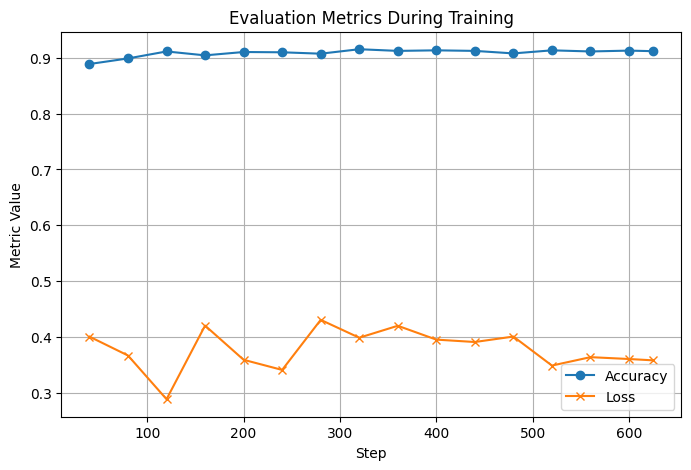

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(eval_logs["step"], eval_logs["eval_accuracy"], label="Accuracy", marker='o')
plt.plot(eval_logs["step"], eval_logs["eval_loss"], label="Loss", marker='x')

plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title("Evaluation Metrics During Training")
plt.grid()
plt.show()

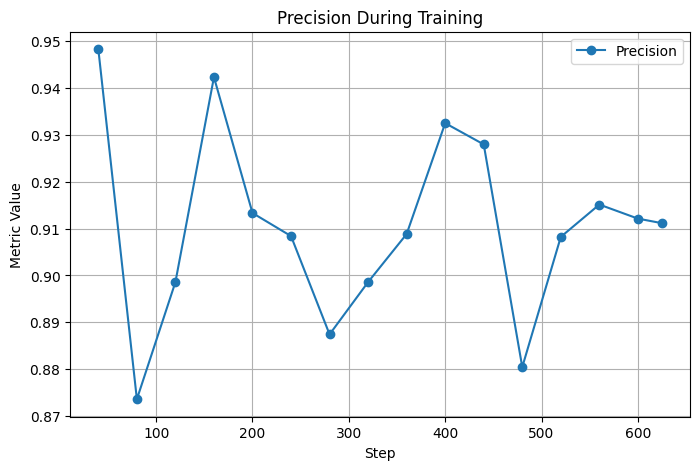

In [49]:
plt.figure(figsize=(8,5))

plt.plot(eval_logs["step"], eval_logs["eval_precision"], label="Precision", marker='o')
# plt.plot(eval_logs["step"], eval_logs["eval_recall"], label="Recall", marker='s')
# plt.plot(eval_logs["step"], eval_logs["eval_f1"], label="F1 Score", marker='^')

plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title("Precision During Training")
plt.grid()
plt.show()

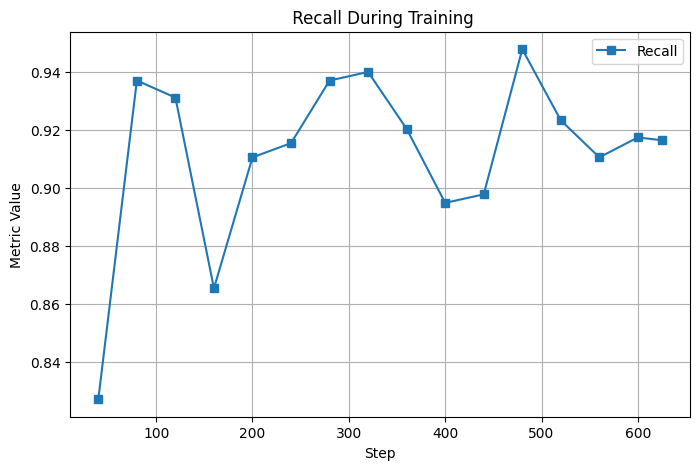

In [48]:
plt.figure(figsize=(8,5))
plt.plot(eval_logs["step"], eval_logs["eval_recall"], label="Recall", marker='s')
# plt.plot(eval_logs["step"], eval_logs["eval_f1"], label="F1 Score", marker='^')

plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title(" Recall During Training")
plt.grid()
plt.show()

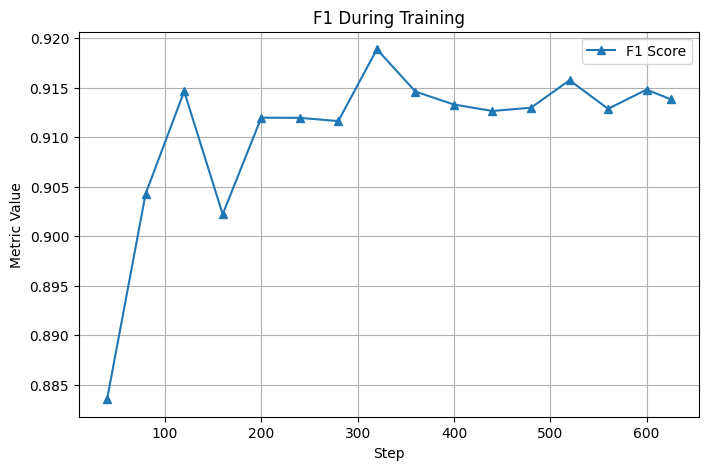

In [50]:
plt.figure(figsize=(8,5))

plt.plot(eval_logs["step"], eval_logs["eval_f1"], label="F1 Score", marker='^')

plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title("F1 During Training")
plt.grid()
plt.show()

In [51]:
# Save model and tokenizer
trainer.save_model("/content/drive/Othercomputers/My Mac/LLM/saved_models/model")
tokenizer.save_pretrained("/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer")

('/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/tokenizer_config.json',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/special_tokens_map.json',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/vocab.txt',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/added_tokens.json',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/tokenizer.json')

In [52]:
model_path = "/content/drive/Othercomputers/My Mac/LLM/saved_models/model"
tokenizer_path = "/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [53]:
import torch

# Check where your model is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

text = " This is the worst product"

# Tokenize
inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    max_length=128
)

# Move inputs to same device as model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()

# Print result
print("Predicted label:", predicted_class)

Predicted label: 0
